In [ ]:

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd



In [ ]:

train_dir = "dataset/train"
val_dir   = "dataset/test"
test_dir  = "dataset/test"

batch_size    = 4
num_workers   = 0
img_size      = (256, 256)
learning_rate = 1e-3
max_epochs    = 2
patience      = 5
loss_alpha    = 0.8
num_examples_to_show = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
class ColorizationDataset(Dataset):
    def __init__(self, directory, img_size=(256,256)):
        exts = {'.png','.jpg','.jpeg','.bmp','.tif','.tiff'}
        self.paths = [p for p in Path(directory).rglob('*') if p.suffix.lower() in exts]
        self.gray_tf = transforms.Compose([
            transforms.Resize(img_size),
            transforms.Grayscale(1),
            transforms.ToTensor(),
        ])
        self.color_tf = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
        ])
        self.augment = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
        ])
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        img = self.augment(img)
        return self.gray_tf(img), self.color_tf(img)

In [14]:
class VGGPerceptualLoss(nn.Module):
    def __init__(self, layers=('relu1_2','relu2_2','relu3_3')):
        super().__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT).features.eval()
        for param in vgg.parameters(): param.requires_grad = False
        self.vgg = vgg.to(device)
        self.layer_map = {'relu1_2':3,'relu2_2':8,'relu3_3':15}

    def forward(self, pred, target):
        pred = pred.to(device)
        target = target.to(device)
        loss = 0
        for idx in self.layer_map.values():
            fp = self.vgg[:idx](pred)
            ft = self.vgg[:idx](target)
            loss += F.l1_loss(fp, ft)
        return loss / len(self.layer_map)

In [15]:
def conv_block(in_c, out_c):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, 3, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, 3, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True)
    )

def up_conv(in_c, out_c):
    return nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)

class UNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=3):
        super().__init__()
        self.enc1 = conv_block(in_ch, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        self.center = conv_block(512, 1024)
        self.pool = nn.MaxPool2d(2)
        self.up4 = up_conv(1024, 512)
        self.dec4 = conv_block(1024, 512)
        self.up3 = up_conv(512, 256)
        self.dec3 = conv_block(512, 256)
        self.up2 = up_conv(256, 128)
        self.dec2 = conv_block(256, 128)
        self.up1 = up_conv(128, 64)
        self.dec1 = conv_block(128, 64)
        self.final = nn.Conv2d(64, out_ch, 1)
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        c  = self.center(self.pool(e4))
        d4 = self.up4(c)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)
        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        out = self.final(d1)
        return torch.sigmoid(out)

In [16]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.8):
        super().__init__()
        self.l1 = nn.L1Loss()
        self.perc = VGGPerceptualLoss()
        self.alpha = alpha
    def forward(self, pred, target):
        return self.alpha*self.l1(pred, target) + (1-self.alpha)*self.perc(pred, target)

In [17]:
def visualize_dataset_samples(dataset, num_samples=5, seed=None):
    if seed is not None: np.random.seed(seed)
    fig, axs = plt.subplots(num_samples,2, figsize=(10, num_samples*3))
    for i in range(num_samples):
        g,c = dataset[np.random.randint(len(dataset))]
        axs[i,0].imshow(g[0], cmap='gray'); axs[i,0].axis('off')
        axs[i,1].imshow(c.permute(1,2,0)); axs[i,1].axis('off')
    plt.tight_layout(); plt.show(); plt.close()

def visualize_colorization(model, loader, device, num_examples=5):
    model.eval()
    batch = next(iter(loader))
    if isinstance(batch, (list, tuple)):
        g, c = batch
    else:
        g, c = batch, None
    batch_size_actual = g.size(0)
    n = min(num_examples, batch_size_actual)
    g = g[:n].to(device)
    if c is not None:
        c = c[:n].to(device)
    with torch.no_grad():
        out = model(g).cpu()
    fig, axs = plt.subplots(n, 3, figsize=(12, n * 3))
    for i in range(n):
        axs[i, 0].imshow(g[i, 0].cpu(), cmap='gray'); axs[i, 0].axis('off'); axs[i,0].set_title('Input')
        if c is not None:
            axs[i, 1].imshow(c[i].cpu().permute(1,2,0)); axs[i,1].axis('off'); axs[i,1].set_title('Ground Truth')
        else:
            axs[i, 1].axis('off'); axs[i,1].set_title('GT N/A')
        img = torch.clamp(out[i], 0, 1).permute(1,2,0)
        axs[i, 2].imshow(img); axs[i,2].axis('off'); axs[i,2].set_title('Prediction')
    plt.tight_layout(); plt.show(); plt.close()

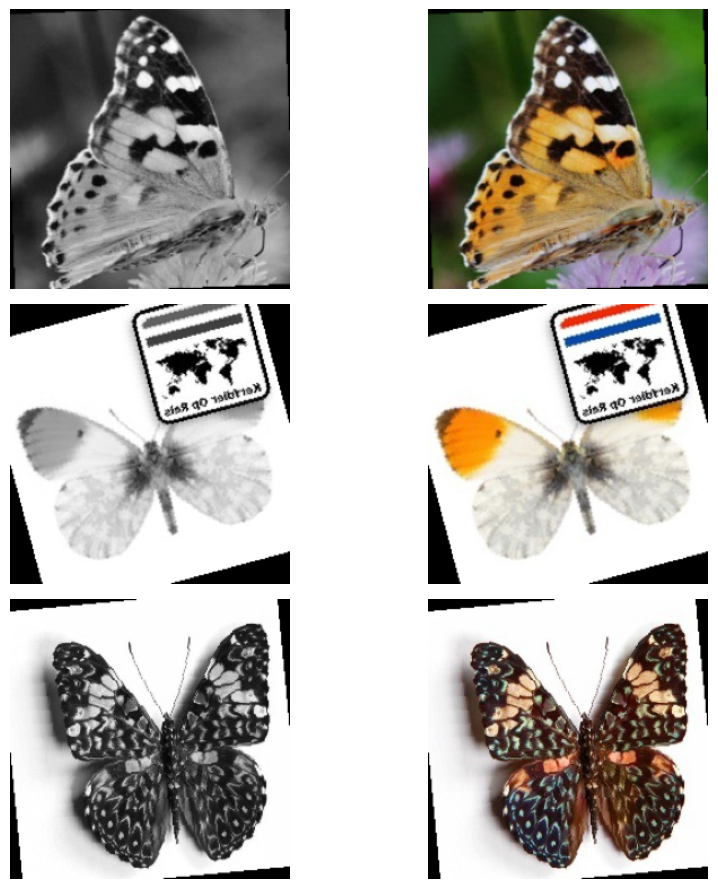

In [18]:
train_ds = ColorizationDataset(train_dir, img_size)
val_ds   = ColorizationDataset(val_dir, img_size)
test_ds  = ColorizationDataset(test_dir, img_size)

visualize_dataset_samples(train_ds, num_samples=3, seed=42)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [9]:
model = UNet(1,3).to(device)
loss_fn = CombinedLoss(loss_alpha)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

best, wait = float('inf'), 0
for epoch in range(max_epochs):
    model.train(); train_loss=0
    for g,c in train_loader:
        g,c = g.to(device), c.to(device)
        optimizer.zero_grad() ; out=model(g)
        l=loss_fn(out,c) ; l.backward() ; optimizer.step()
        train_loss += l.item()
    train_loss /= len(train_loader)

    model.eval(); val_loss=0
    with torch.no_grad():
        for g,c in val_loader:
            g,c = g.to(device), c.to(device)
            val_loss += loss_fn(model(g),c).item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch}: train={train_loss:.4f}, val={val_loss:.4f}")
    if val_loss < best:
        best = val_loss
        torch.save(model.state_dict(), 'best.pth')
        wait = 0
    else:
        wait += 1
        if wait >= patience: break

print("Best Val Loss:", best)

Epoch 0: train=0.1640, val=0.1405
Epoch 1: train=0.1485, val=0.1433
Best Val Loss: 0.14054693947606312


In [31]:
model = UNet(1,3).to(device)
loss_fn = CombinedLoss(loss_alpha)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.load_state_dict(torch.load('models/colorizer_model.pth', map_location='cpu' if device is None else device))
model.eval()
if device is not None:
    model = model.to(device)
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

test_loss = 0
with torch.no_grad():
    for g, c in test_loader:
        g, c = g.to(device), c.to(device)
        test_loss += loss_fn(model(g), c).item()
test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

C:\Users\alish\AppData\Local\Temp\ipykernel_13788\2721363076.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/colorizer_model.pth

Test Loss: 0.1111


In [ ]:
import torch
from torchvision import transforms
from PIL import Image

def colorize_and_save(input_path, output_path, model_path='colorize_best.pth', img_size=(256,256), device=None):
    # Load model
    model = UNet(1,3).to(device)
    loss_fn = CombinedLoss(loss_alpha)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.load_state_dict(torch.load(model_path, map_location='cpu' if device is None else device))
    model.eval()
    if device is not None:
        model = model.to(device)
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
    
    # Preprocess input image
    img = Image.open(input_path).convert('L')
    tf = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
    ])
    g = tf(img).unsqueeze(0).to(device)  # shape: (1, 1, H, W)
    
    # Predict
    with torch.no_grad():
        out = model(g)
    out_img = out.squeeze(0).cpu().clamp(0,1).permute(1,2,0).numpy()
    out_img = (out_img * 255).astype('uint8')
    out_pil = Image.fromarray(out_img)
    out_pil.save(output_path)
    print(f"Saved colorized image to {output_path}")



In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

def colorize_and_save(input_path, output_path, model_path='models\colorizer_model.pth', img_size=(256,256), device=None):
    # Load model
    model = UNet(1,3).to(device)
    model.load_state_dict(torch.load(model_path, map_location='cpu' if device is None else device))
    model.eval()
    if device is not None:
        model = model.to(device)
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)

    img = Image.open(input_path).convert('L')
    tf = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
    ])
    g = tf(img).unsqueeze(0).to(device) 

    with torch.no_grad():
        out = model(g)
    out_img = out.squeeze(0).cpu().clamp(0,1).permute(1,2,0).numpy()
    out_img_uint8 = (out_img * 255).astype('uint8')
    out_pil = Image.fromarray(out_img_uint8)
    out_pil.save(output_path)
    print(f"Saved colorized image to {output_path}")

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img, cmap='gray')
    axs[0].set_title('Input Grayscale')
    axs[0].axis('off')
    axs[1].imshow(out_img)
    axs[1].set_title('Colorized Output')
    axs[1].axis('off')
    plt.tight_layout()
    plt.show()

C:\Users\alish\AppData\Local\Temp\ipykernel_13788\3093879034.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location='c

Saved colorized image to output_colorized.png


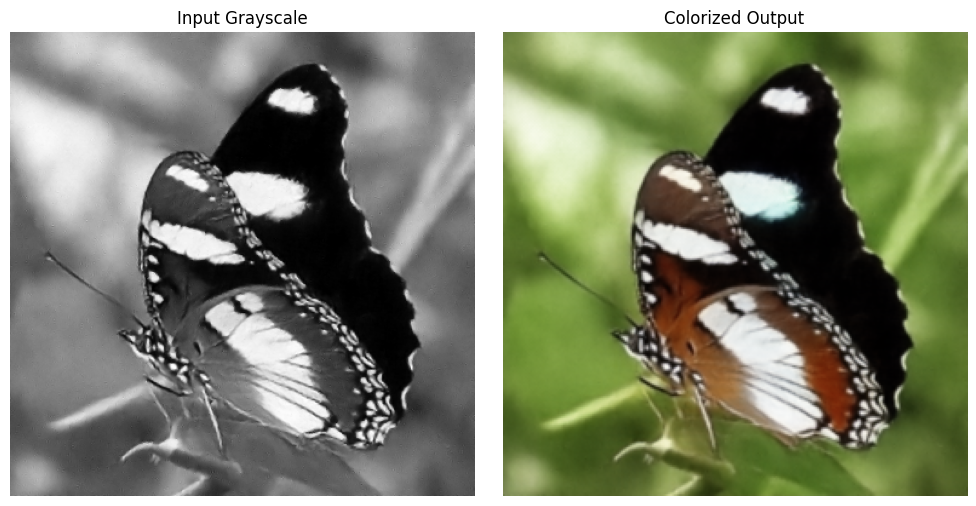

In [25]:
colorize_and_save('results\denoiser\Image_1313_reconstructed_denoised.png', 'output_colorized.png')

In [ ]:
model.load_state_dict(torch.load('models/colorizer_model.pth'))
visualize_colorization(model, test_loader, device, num_examples=num_examples_to_show)

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

def colorize_and_save(
    input_path, 
    output_path, 
    model_path='models/colorizer_model.pth', 
    img_size=(256,256), 
    device=None, 
    ground_truth_path=None
):
    # Load model
    model = UNet(1,3).to(device)
    model.load_state_dict(torch.load(model_path, map_location='cpu' if device is None else device))
    model.eval()
    if device is not None:
        model = model.to(device)
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
    
    # Preprocess input image
    img = Image.open(input_path).convert('L')
    tf = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
    ])
    g = tf(img).unsqueeze(0).to(device) 
    
    # Predict
    with torch.no_grad():
        out = model(g)
    out_img = out.squeeze(0).cpu().clamp(0,1).permute(1,2,0).numpy()
    out_img_uint8 = (out_img * 255).astype('uint8')
    out_pil = Image.fromarray(out_img_uint8)
    out_pil.save(output_path)
    print(f"Saved colorized image to {output_path}")

    # Plot: Input, Output, Ground Truth
    ncols = 3 if ground_truth_path else 2
    fig, axs = plt.subplots(1, ncols, figsize=(5*ncols, 5))
    axs[0].imshow(img, cmap='gray')
    axs[0].set_title('Input Grayscale')
    axs[0].axis('off')
    axs[1].imshow(out_img)
    axs[1].set_title('Colorized Output')
    axs[1].axis('off')
    if ground_truth_path:
        gt_img = Image.open(ground_truth_path).convert('RGB').resize(img_size)
        axs[2].imshow(gt_img)
        axs[2].set_title('Ground Truth')
        axs[2].axis('off')
    plt.tight_layout()
    plt.show()

C:\Users\alish\AppData\Local\Temp\ipykernel_13788\496011939.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location='c

Saved colorized image to results/output_colorized.png


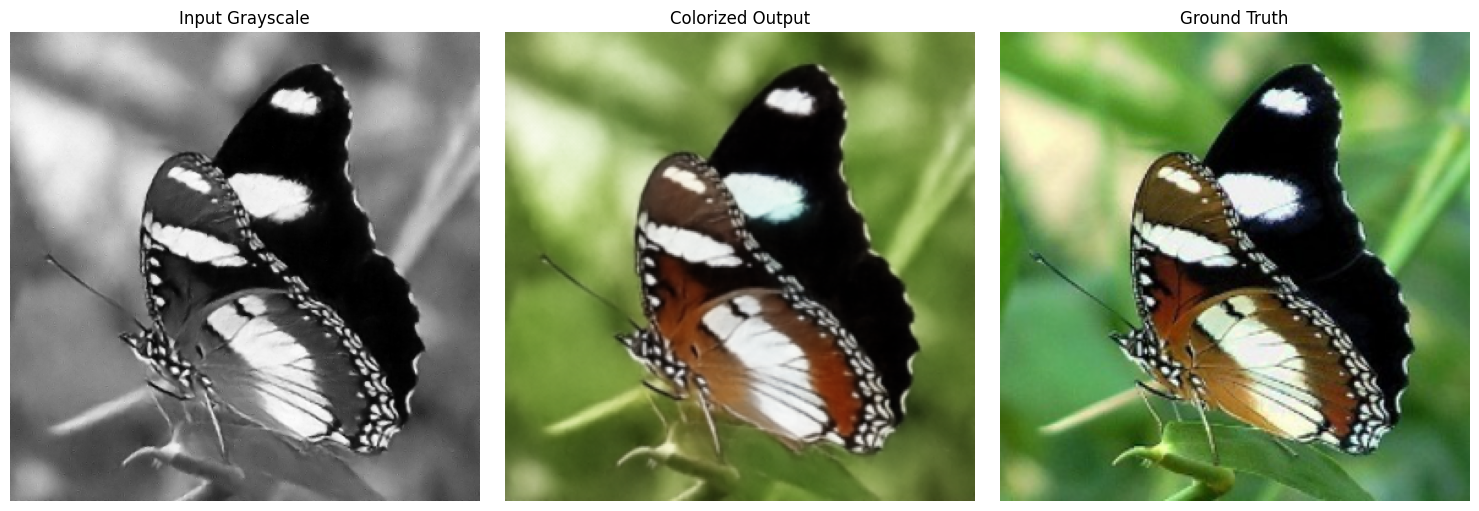

In [38]:
colorize_and_save(
    input_path='results\denoiser\Image_1313_reconstructed_denoised.png',
    output_path='results/output_colorized.png',
    ground_truth_path='dataset/test/Image_1313.jpg'
)

In [ ]:
import os
import random
from PIL import Image
from torchvision import transforms
import torch

def colorize_folder(input_folder, output_folder='colorization_result', model_path='models\colorizer_model.pth', img_size=(256,256), device=None, max_samples=100):
    # Prepare output folder
    os.makedirs(output_folder, exist_ok=True)
    # Get all image files
    exts = ('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')
    all_files = [f for f in os.listdir(input_folder) if f.lower().endswith(exts)]
    sample_files = random.sample(all_files, min(max_samples, len(all_files)))
    
    # Load model
    model = UNet(1,3)
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    tf = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
    ])
    
    for fname in all_files:
        input_path = os.path.join(input_folder, fname)
        output_path = os.path.join(output_folder, os.path.splitext(fname)[0] + '_colorized.png')
        img = Image.open(input_path).convert('L')
        g = tf(img).unsqueeze(0).to(device)
        with torch.no_grad():
            out = model(g)
        out_img = out.squeeze(0).cpu().clamp(0,1).permute(1,2,0).numpy()
        out_img = (out_img * 255).astype('uint8')
        out_pil = Image.fromarray(out_img)
        out_pil.save(output_path)
    print(f"Saved colorized image to {output_folder}")




In [ ]:
colorize_folder(
    input_folder= 'results\denoiser', 
    output_folder='results/colorization', 
    model_path='models/colorizer_model.pth', 
    img_size=(256,256)
    )